In [1]:
import numpy as np

In [2]:
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Conv2DTranspose, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add

# Creating Convolutional Blocks with Max-Pooling

This code defines a function Convblock used to create a block of convolutional layers followed by a max-pooling layer. The function takes three parameters: channel_dimension (number of output channels for the convolutional layers), block_no (index of the block), and no_of_convs (number of convolutional layers in the block). It iterates over the specified number of convolutional layers, each with a 3x3 kernel size and ReLU activation, and appends them to a list. Then, it adds a max-pooling layer with a 2x2 pool size and 2x2 strides. Finally, it returns the list of layers composing the block. This function helps in creating convolutional blocks commonly used in deep neural networks for tasks like image classification or object detection.

In [4]:
# Function to create to a series of CONV layers followed by Max pooling layer
def Convblock(channel_dimension, block_no, no_of_convs) :
    Layers = []
    for i in range(no_of_convs) :

        Conv_name = "conv"+str(block_no)+"_"+str(i+1)

        # A constant kernel size of 3*3 is used for all convolutions
        Layers.append(Convolution2D(channel_dimension,kernel_size = (3,3),padding = "same",activation = "relu",name = Conv_name))

    Max_pooling_name = "pool"+str(block_no)

    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = Max_pooling_name))

    return Layers

# FCN-16 Architecture Construction

This code defines a helper function, FCN_16_helper, to construct the FCN-16 architecture for semantic segmentation. It sets up a Sequential model and adds convolutional blocks with varying numbers of convolutional layers, followed by fully convolutional layers. The function replaces the fully connected layers of the VGG Net with convolutional layers. Finally, it includes transposed convolutional layers for upsampling to the original image size, followed by cropping to adjust for the differences in dimensions. The output is the constructed FCN-16 model.

In [5]:
#Helper function to create Sequential part of the Architecture
def FCN_16_helper(image_size):
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (image_size,image_size,3)))


    for l in Convblock(64,1,2) :
        model.add(l)

    for l in Convblock(128,2,2):
        model.add(l)

    for l in Convblock(256,3,3):
        model.add(l)

    for l in Convblock(512,4,3):
        model.add(l)

    for l in Convblock(512,5,3):
        model.add(l)


    model.add(Convolution2D(4096,kernel_size=(7,7),padding = "same",activation = "relu",name = "fc6"))

    #Replacing fully connnected layers of VGG Net using convolutions
    model.add(Convolution2D(4096,kernel_size=(1,1),padding = "same",activation = "relu",name = "fc7"))


    # Gives the classifications scores for each of the 21 classes including background
    model.add(Convolution2D(21,kernel_size=(1,1),padding="same",activation="relu",name = "score_fr"))


    Conv_size = model.layers[-1].output_shape[2] #16 if image size if 512
    print(Conv_size)

    model.add(Conv2DTranspose(21,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score2"))

    # O = ((I-K+2*P)/Stride)+1
    # O = Output dimesnion after convolution
    # I = Input dimnesion
    # K = kernel Size
    # P = Padding

    # I = (O-1)*Stride + K
    Deconv_size = model.layers[-1].output_shape[2] #34 if image size is 512*512

    print(Deconv_size)
    # 2 if image size is 512*512
    Extra = (Deconv_size - 2*Conv_size)

    print(Extra)

    #Cropping to get correct size
    model.add(Cropping2D(cropping=((0,Extra),(0,Extra))))
    return model

output = FCN_16_helper(512)
print(len(output.layers))
print(output.layers[14])

16
34
2
24


# Enhancing FCN-16 with Skip Connections and Upsampling

This code defines a function FCN_16 that extends the FCN-16 architecture by incorporating skip connections and upsampling. It first constructs the FCN-16 model using the FCN_16_helper function. Then, it calculates the size of the convolutional output after the sequential block. Skip connections are added by combining the output of a convolutional layer with the output of a previous layer using element-wise addition. Finally, upsampling is performed using transposed convolutional layers to restore the image to its original size. Cropping is applied to adjust for any differences in dimensions. The resulting model is returned.

In [6]:
def FCN_16(image_size) :
    fcn_16 = FCN_16_helper(512)

    #Calculating conv size after the sequential block
    #32 if image size is 512*512
    Conv_size = fcn_16.layers[-1].output_shape[2]

    skip_con = Convolution2D(21,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool4")

    #Addig skip connection which takes adds the output of Max pooling layer 4 to current layer
    Summed = add(inputs = [skip_con(fcn_16.layers[14].output),fcn_16.layers[-1].output])


    Up = Conv2DTranspose(21,kernel_size=(32,32),strides = (16,16),padding = "valid",activation = None,name = "upsample_new")

    #528 if image size is 512*512
    Deconv_size = (Conv_size-1)*16+32

    #16 if image size is 512*512
    extra_margin = (Deconv_size - Conv_size*16)

    #Cropping to get the original size of the image
    crop = Cropping2D(cropping = ((0,extra_margin),(0,extra_margin)))
    return Model(fcn_16.input, crop(Up(Summed)))

output = FCN_16(512)

print(output.summary())

16
34
2
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 permute_2_input (InputLaye  [(None, 512, 512, 3)]        0         []                            
 r)                                                                                               
                                                                                                  
 permute_2 (Permute)         (None, 512, 512, 3)          0         ['permute_2_input[0][0]']     
                                                                                                  
 conv1_1 (Conv2D)            (None, 512, 512, 64)         1792      ['permute_2[0][0]']           
                                                                                                  
 conv1_2 (Conv2D)            (None, 512, 512, 64)         36928     ['conv1_1[0][0]'] 

Next, an FCN-16 model for semantic segmentation is instantiated with an input image size of 512x512 pixels. The FCN_16 function constructs the model, incorporating skip connections and upsampling layers. The summary() method is then called on the model (fcn16_model) to display a summary of its architecture, including the layer types, output shapes, and the number of parameters.

In [7]:
image_size = 512
fcn16_model = FCN_16(512)
fcn16_model.summary()

16
34
2
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 permute_3_input (InputLaye  [(None, 512, 512, 3)]        0         []                            
 r)                                                                                               
                                                                                                  
 permute_3 (Permute)         (None, 512, 512, 3)          0         ['permute_3_input[0][0]']     
                                                                                                  
 conv1_1 (Conv2D)            (None, 512, 512, 64)         1792      ['permute_3[0][0]']           
                                                                                                  
 conv1_2 (Conv2D)            (None, 512, 512, 64)         36928     ['conv1_1[0][0]'

In [8]:
from keras.utils import plot_model

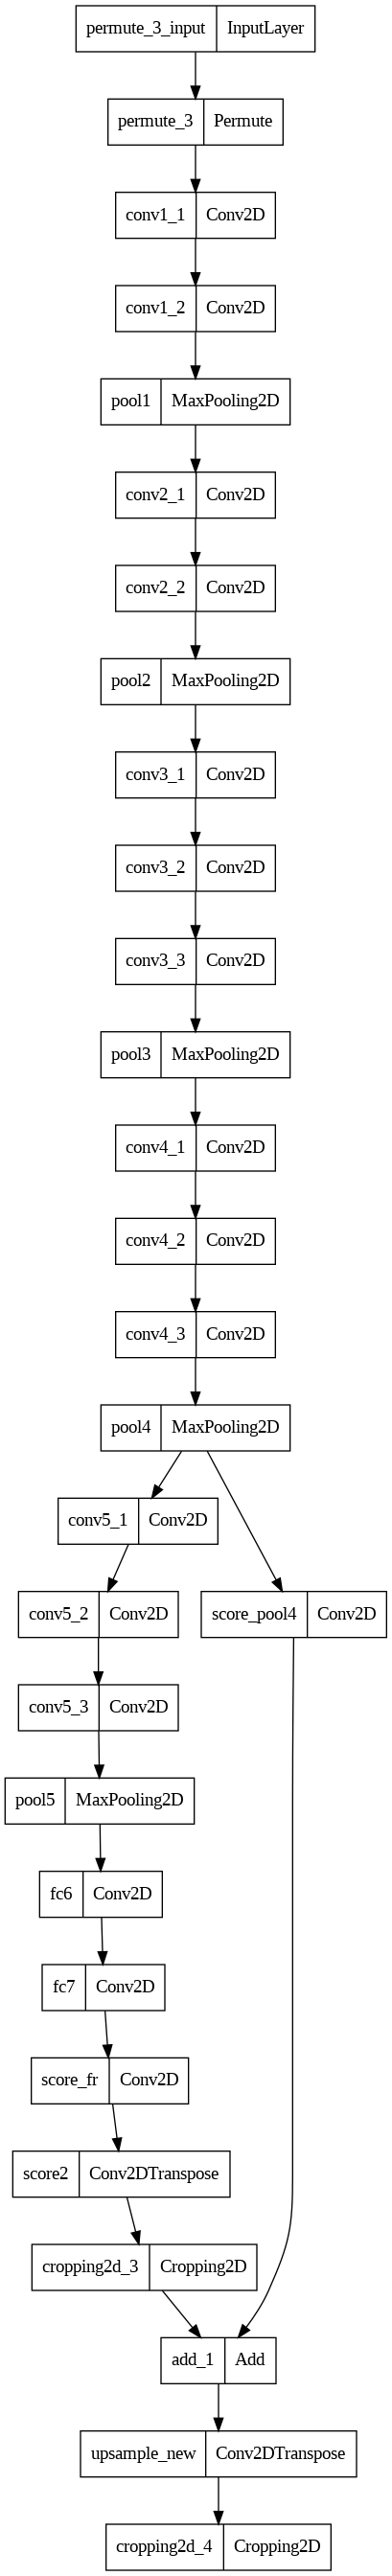

In [9]:
plot_model(fcn16_model,"FCN-16.png")

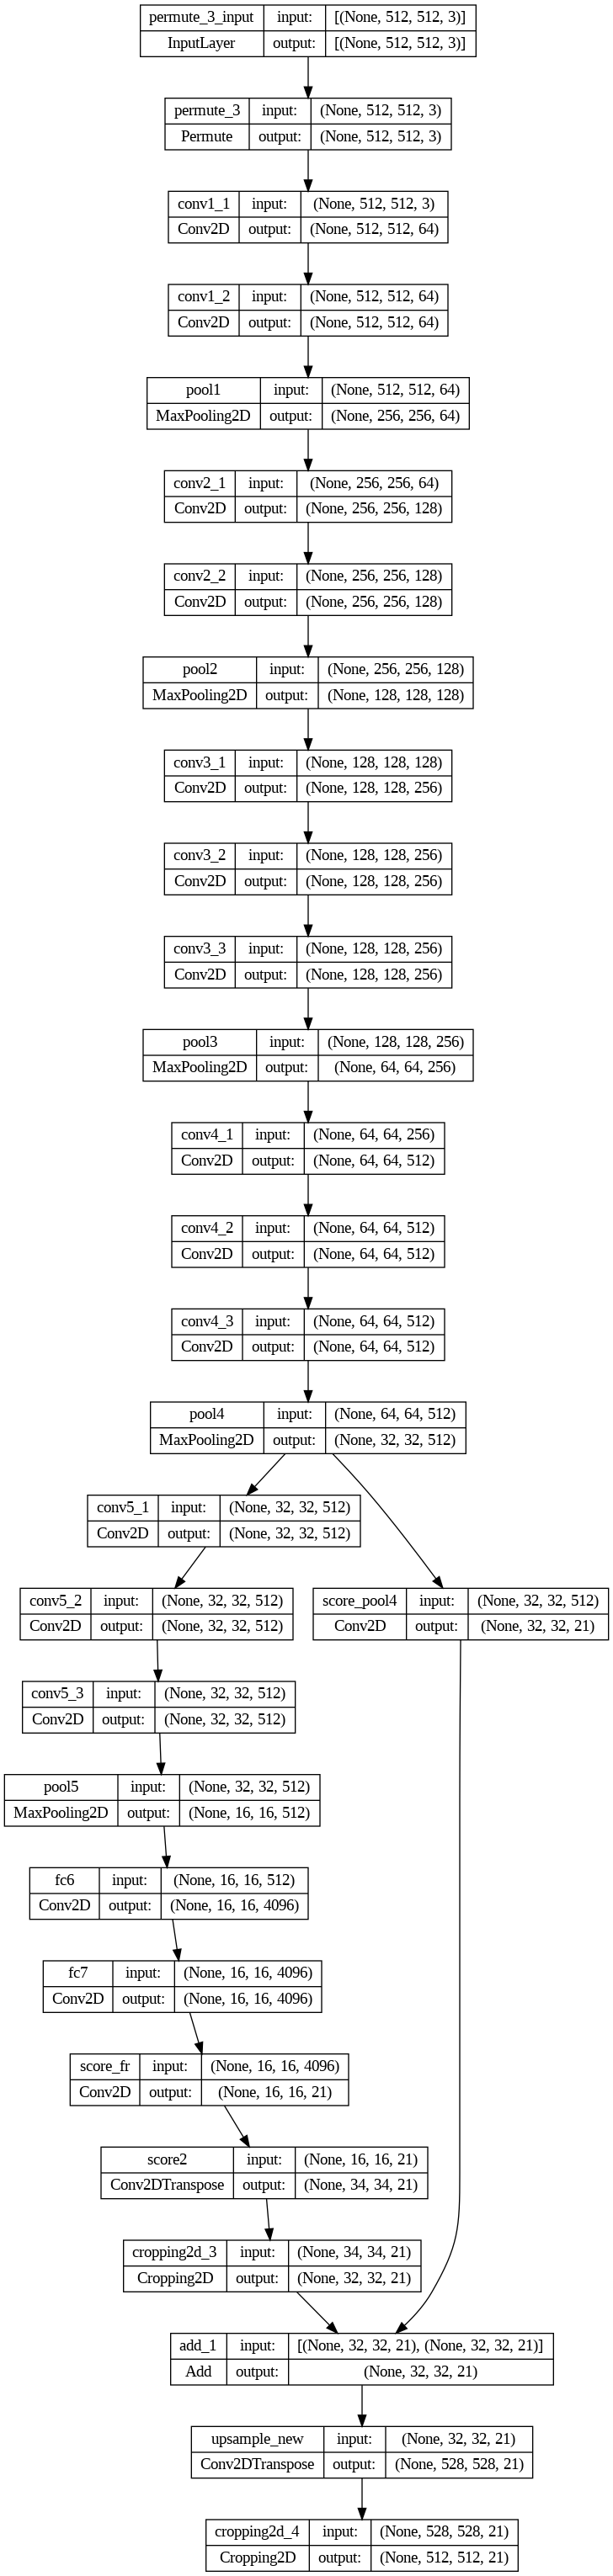

In [10]:
plot_model(fcn16_model,"FCN-16_withshape.png",show_shapes=True)

In [11]:
from scipy.io import loadmat

# Downloading and Loading Pre-trained FCN-16 Model

This code snippet downloads a pre-trained FCN-16 model (pascal-fcn16s-dag.mat) from an online repository using the wget command. After downloading, the model is loaded into memory using the loadmat function from SciPy, with appropriate settings to handle MATLAB data structures. The model's layers and parameters are extracted from the loaded data, and a description of the classes is retrieved from the metadata. This process sets up the pre-trained FCN-16 model for further use in semantic segmentation tasks.

In [12]:
!wget https://www.vlfeat.org/matconvnet/models/pascal-fcn16s-dag.mat
data = loadmat('pascal-fcn16s-dag.mat', matlab_compatible=False, struct_as_record=False)
layers = data['layers']
params = data['params']
description = data['meta'][0,0].classes[0,0].description

--2024-05-09 19:38:01--  https://www.vlfeat.org/matconvnet/models/pascal-fcn16s-dag.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 75.119.206.150
Connecting to www.vlfeat.org (www.vlfeat.org)|75.119.206.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 500215534 (477M)
Saving to: ‘pascal-fcn16s-dag.mat’

pascal-fcn16s-dag.m 100%[===================>] 477.04M  72.4MB/s    in 5.9s    

2024-05-09 19:38:07 (80.7 MB/s) - ‘pascal-fcn16s-dag.mat’ saved [500215534/500215534]



Next, a dictionary named class2index is created to map class names to their corresponding indices. The code iterates through the classes in the description array, assigning each class name a unique index starting from zero. The resulting dictionary is then printed, displaying the class names sorted alphabetically along with their respective indices. This dictionary can be useful for quickly accessing class indices based on class names in semantic segmentation tasks.

In [13]:
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i

print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


# Transferring MATLAB Model to Keras

This function facilitates the transfer of weights and biases from a MATLAB-trained model to a Keras model. It first retrieves the names of layers in the Keras model. Then, it iterates through the parameters of the MATLAB model, matching each layer's name with its counterpart in Keras. If a matching layer is found, the weights and biases are extracted from the MATLAB parameters, transposed if necessary, and set to the corresponding layer in the Keras model. This process ensures that the Keras model inherits the learned parameters from the MATLAB model, enabling seamless integration and transfer of knowledge between different frameworks.

In [14]:
def copy_mat_to_keras(kmodel):

    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (0, 1, 2, 3) # WARNING : important setting as 2 of the 4 axis have same size dimension

    for i in range(0, params.shape[1]-1, 2):
        matname = '_'.join(params[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print('found : ', (str(matname), kindex))
            l_weights = params[0,i].value
            l_bias = params[0,i+1].value
            f_l_weights = l_weights.transpose(prmt)
            if False: # WARNING : this depends on "image_data_format":"channels_last" in keras.json file
                f_l_weights = np.flip(f_l_weights, 0)
                f_l_weights = np.flip(f_l_weights, 1)
            print(f_l_weights.shape, kmodel.layers[kindex].get_weights()[0].shape)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
        else:
            print('not found : ', str(matname))

In [15]:
copy_mat_to_keras(fcn16_model)

found :  ('conv1_1', 2)
(3, 3, 3, 64) (3, 3, 3, 64)
found :  ('conv1_2', 3)
(3, 3, 64, 64) (3, 3, 64, 64)
found :  ('conv2_1', 5)
(3, 3, 64, 128) (3, 3, 64, 128)
found :  ('conv2_2', 6)
(3, 3, 128, 128) (3, 3, 128, 128)
found :  ('conv3_1', 8)
(3, 3, 128, 256) (3, 3, 128, 256)
found :  ('conv3_2', 9)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv3_3', 10)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv4_1', 12)
(3, 3, 256, 512) (3, 3, 256, 512)
found :  ('conv4_2', 13)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv4_3', 14)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_1', 16)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_2', 17)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_3', 18)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('fc6', 20)
(7, 7, 512, 4096) (7, 7, 512, 4096)
found :  ('fc7', 21)
(1, 1, 4096, 4096) (1, 1, 4096, 4096)
found :  ('score_fr', 22)
(1, 1, 4096, 21) (1, 1, 4096, 21)
found :  ('score2', 23)
(4, 4, 21, 21) (4, 4, 21, 21)
found :  ('score_pool

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [21]:
im = Image.open('/content/cycle.png')
im = im.resize((image_size,image_size))

In [19]:
from skimage.io import imread, imsave

(512, 512, 3)


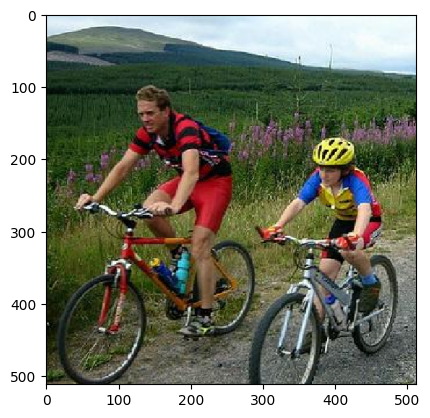

In [22]:
plt.imshow(np.asarray(im))
print(np.asarray(im).shape)

In [23]:
import copy
import math

This function, prediction, takes a Keras model (kmodel) and an image (crpimg) as input and performs prediction on the image. If the transform parameter is set to True, it applies a specific transformation to the image data. This transformation involves subtracting certain mean values from each color channel and swapping the red and blue channels. Finally, the function expands the dimensions of the image array to match the input shape expected by the Keras model and returns the prediction result obtained by feeding the transformed image to the model.

In [24]:
def prediction(kmodel, crpimg, transform=False):
	# INFO : crpimg should be a cropped image of the right dimension


	imarr = np.array(crpimg).astype(np.float32)

	if transform:
		imarr[:, :, 0] -= 129.1863
		imarr[:, :, 1] -= 104.7624
		imarr[:, :, 2] -= 93.5940

		aux = copy.copy(imarr)
		imarr[:, :, 0] = aux[:, :, 2]
		imarr[:, :, 2] = aux[:, :, 0]

	# imarr[:,:,0] -= 129.1863
	# imarr[:,:,1] -= 104.7624
	# imarr[:,:,2] -= 93.5940

	# imarr = imarr.transpose((2, 0, 1))
	imarr = np.expand_dims(imarr, axis=0)

	return kmodel.predict(imarr)

In [25]:
crpim = im
preds = prediction(fcn16_model, crpim, transform=False)

1/1 [==============================] - 5s 5s/step


# Visualizing Semantic Segmentation Results

This code snippet visualizes the results of semantic segmentation. It first extracts the class predictions from the model's output (preds) for the 'person' class and identifies the most likely class for each pixel using np.argmax. Then, it creates a masked version of the segmentation map where non-person regions are masked out. Finally, it plots the original image (crpim), the segmentation map, and the overlay of the segmentation map on the original image using matplotlib subplots. This visualization helps in understanding how well the model is performing in segmenting different classes in the image.

(1, 512, 512, 21)
<class 'numpy.ndarray'>
512
(512, 512)
(512, 512)


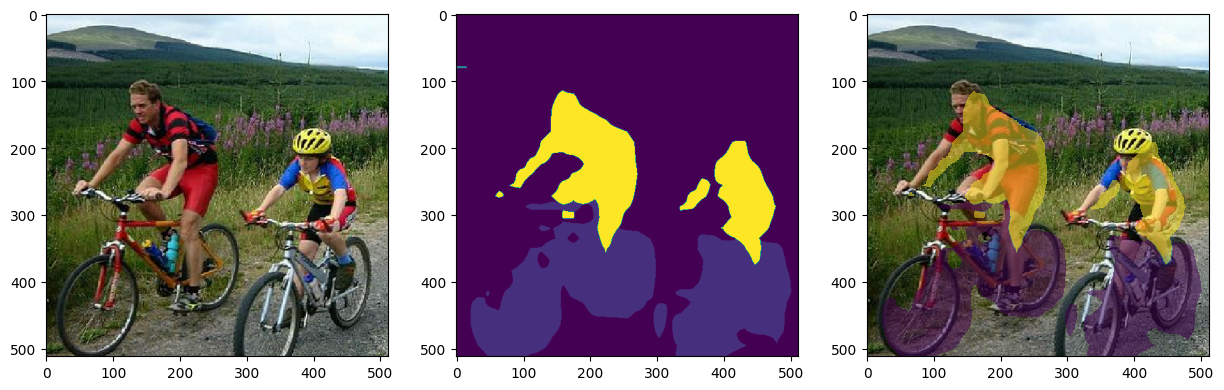

In [26]:
#imperson = preds[0,class2index['person'],:,:]
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(type(imclass))
print(len(imclass))
print(imclass.shape)
print(imclass.shape)

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [27]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

0 background
2 bicycle
7 car
15 person


# Test you own image

It's time to put your skills to the test! Try running the segmentation code on your own images and see the segmented results. Experiment with different types of images to observe how well the model performs in segmenting various classes. Make sure your image contains at least one of the following classes the model was trained on:
'aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'

In [50]:
im1 = Image.open('/content/aeroplane.jpg')
im1 = im1.resize((image_size,image_size))

(512, 512, 3)


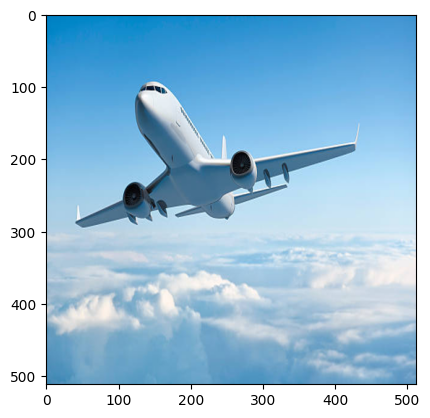

In [51]:
plt.imshow(np.asarray(im1))
print(np.asarray(im1).shape)

In [52]:
preds = prediction(fcn16_model, im1, transform=False)

1/1 [==============================] - 4s 4s/step


(1, 512, 512, 21)
<class 'numpy.ndarray'>
512
(512, 512)
(512, 512)


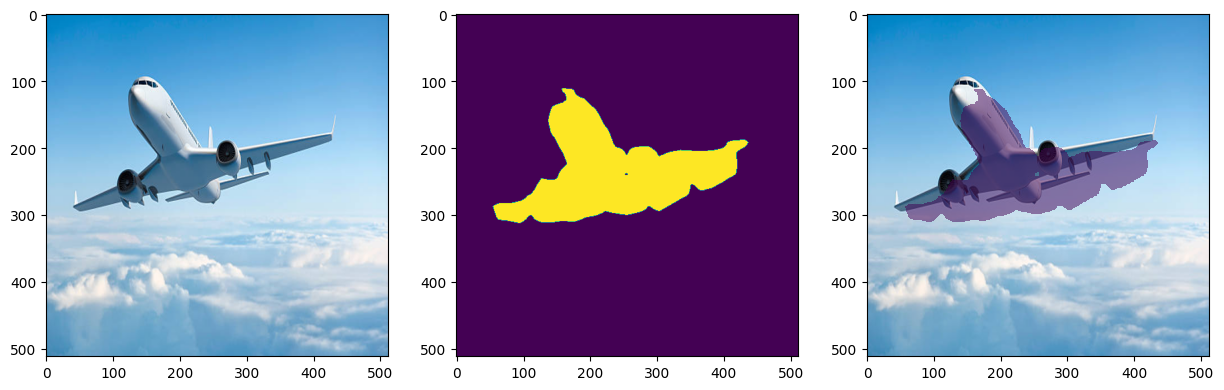

In [53]:
#imperson = preds[0,class2index['person'],:,:]
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(type(imclass))
print(len(imclass))
#imsave("Annotation2.png",imclass)
print(imclass.shape)
print(imclass.shape)
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im1) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im1) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [54]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

0 background
1 aeroplane
